In [1]:
import os
import pandas as pd
from collections import defaultdict
import shutil
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

In [5]:
directory = os.fsencode("/home/zluo/CNV_pipeline/input/txt_orig")

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename[4] != "_" and filename[-3:] == "txt":
        filename_lst = filename[:-4].split("-")
        new_filename = filename_lst[1] + "-" + filename_lst[2] + "-" + filename_lst[3] + "_" + filename_lst[0] + ".txt"
        os.rename("/home/zluo/CNV_pipeline/input/txt_orig/" + filename,"/home/zluo/CNV_pipeline/input/txt_orig/" + new_filename)

Start here

In [4]:
directory = os.fsencode("/home/zluo/CNV_pipeline/input/txt_orig")
fm_count = defaultdict(int)
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename[-3:] == "txt":
        fm_code = filename[:4]
        fm_count[fm_code] += 1
    else:
        continue

In [5]:
path_lst = []
fm_code_lst = []
directory = os.fsencode("/home/zluo/CNV_pipeline/input/txt_orig")
for file in sorted(os.listdir(directory)):
    filename = os.fsdecode(file)
    if filename[-3:] == "txt":
        fm_code = filename[:4]
        fm_code_lst.append(fm_code)
        if fm_count[fm_code] == 3:
            full_path = "/home/zluo/CNV_pipeline/input/txt_orig/" + filename
            if full_path not in path_lst:
                path_lst.append(full_path)
    else:
        continue
        
fm_code_lst = set(fm_code_lst)

In [10]:
with open('/home/zluo/PennCNV-1.0.5/input.listfile', 'w') as f:
    for path in path_lst:
        f.write(path+'\n')

Running trio cnv calling

In [11]:
length = len(path_lst)
for idx in range(0, len(path_lst), 3):
    fm_code = path_lst[idx][26:30]
    f1 = path_lst[idx]
    f2 = path_lst[idx + 1]
    f3 = path_lst[idx + 2]
    out_file = fm_code + ".triocnv"
    print("running on " + out_file + " which is " + str(idx+1) + " out of " + str(length))
    subprocess.run(["PennCNV-1.0.5/detect_cnv.pl", "-trio", "-hmm", "/home/sal004/software/penncnv/lib/exome.hmm", "-pfb", "/home/sal004/software/penncnv/lib/humancoreexome-12v1-1_a.pfb", "-cnv", "/home/zluo/PennCNV-1.0.5/fm_out.rawcnv", f1, f2, f3, "-out", out_file], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)

running on 5327.triocnv which is 1 out of 432
running on 5341.triocnv which is 4 out of 432
running on 5443.triocnv which is 7 out of 432
running on 5514.triocnv which is 10 out of 432
running on 5515.triocnv which is 13 out of 432
running on 5516.triocnv which is 16 out of 432
running on 5555.triocnv which is 19 out of 432
running on 5559.triocnv which is 22 out of 432
running on 5560.triocnv which is 25 out of 432
running on 5561.triocnv which is 28 out of 432
running on 5562.triocnv which is 31 out of 432
running on 5643.triocnv which is 34 out of 432
running on 5654.triocnv which is 37 out of 432
running on 5656.triocnv which is 40 out of 432
running on 5668.triocnv which is 43 out of 432
running on 5675.triocnv which is 46 out of 432
running on 5677.triocnv which is 49 out of 432
running on 5680.triocnv which is 52 out of 432
running on 5684.triocnv which is 55 out of 432
running on 5689.triocnv which is 58 out of 432
running on 5696.triocnv which is 61 out of 432
running on 5697.

In [13]:
columns=['chr', 'numsnp', 'length', 'state_cn', 'loc', 'startsnp', 'endsnp', 'member', 'triostate', 'fm_code', 'de_novo']
data = []
for fm_code in fm_code_lst:
    triostate_lst = []
    if not os.path.exists(f"{fm_code}.triocnv"):
        continue
    with open(f"{fm_code}.triocnv") as f:
        for line in f.readlines():
            triostate = line.split()
            if len(triostate) == 0 or len(triostate[-1]) != 13:
                continue

            trio_code = triostate[-1][-3:]
            p = trio_code[:-1]
            c = trio_code[-1]
            triostate.append(fm_code)
            
            if c not in p and c != "3":
                triostate.append(True)
            else:
                triostate.append(False)
            data.append(triostate)

In [14]:
de_novo_df = pd.DataFrame(data, columns=columns)
de_novo_df['numsnp'] = de_novo_df['numsnp'].apply(lambda x: int(x.split("=")[-1]))
de_novo_df['length'] = de_novo_df['length'].apply(lambda x: int(x.split("=")[-1].replace(",", "")))
de_novo_df['startsnp'] = de_novo_df['startsnp'].apply(lambda x: x.split("=")[-1])
de_novo_df['endsnp'] = de_novo_df['endsnp'].apply(lambda x: x.split("=")[-1])
de_novo_df['triostate'] = de_novo_df['triostate'].apply(lambda x: int(x.split("=")[-1]))
de_novo_df['state'] = de_novo_df['state_cn'].apply(lambda x: int(x.split(",")[0][-1]))
de_novo_df['cn'] = de_novo_df['state_cn'].apply(lambda x: int(x.split(",")[1][-1]))
de_novo_df['chr_n'] = de_novo_df['chr'].apply(lambda x: int(x.split(":")[0][3:]))
de_novo_df['chr_s_s'] = de_novo_df['chr'].apply(lambda x: int(x.split(":")[-1].split('-')[0]))
de_novo_df['chr_s_e'] = de_novo_df['chr'].apply(lambda x: int(x.split(":")[-1].split('-')[1]))
de_novo_df.to_csv("de_novo.csv")

Start from here:

In [2]:
de_novo_df = pd.read_csv("de_novo.csv", index_col=0)

In [3]:
de_novo_df['fm_code'].value_counts()

5922    1472
6701    1302
5514    1289
5735    1222
5961    1137
        ... 
6685      53
6383      52
6289      44
6056      43
5560      33
Name: fm_code, Length: 144, dtype: int64

In [17]:
denovo_per_fm = de_novo_df.groupby('fm_code')['de_novo'].sum().sort_values(ascending=False)

<AxesSubplot:>

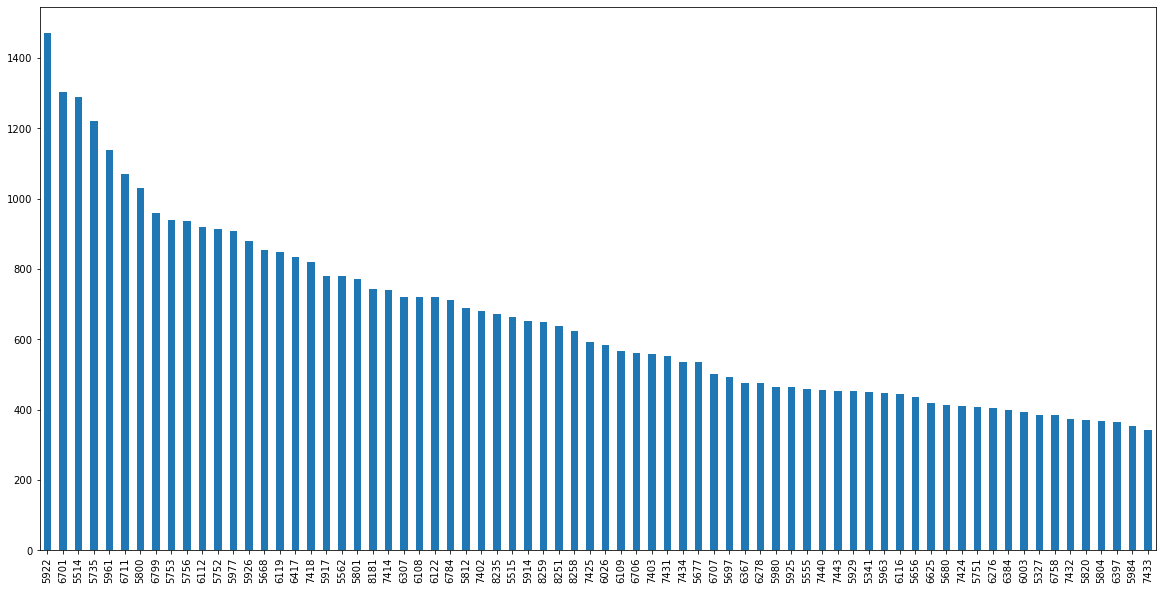

In [18]:
de_novo_df['fm_code'].value_counts()[:int(len(denovo_per_fm)/2)].plot.bar(figsize=(20,10))

<AxesSubplot:>

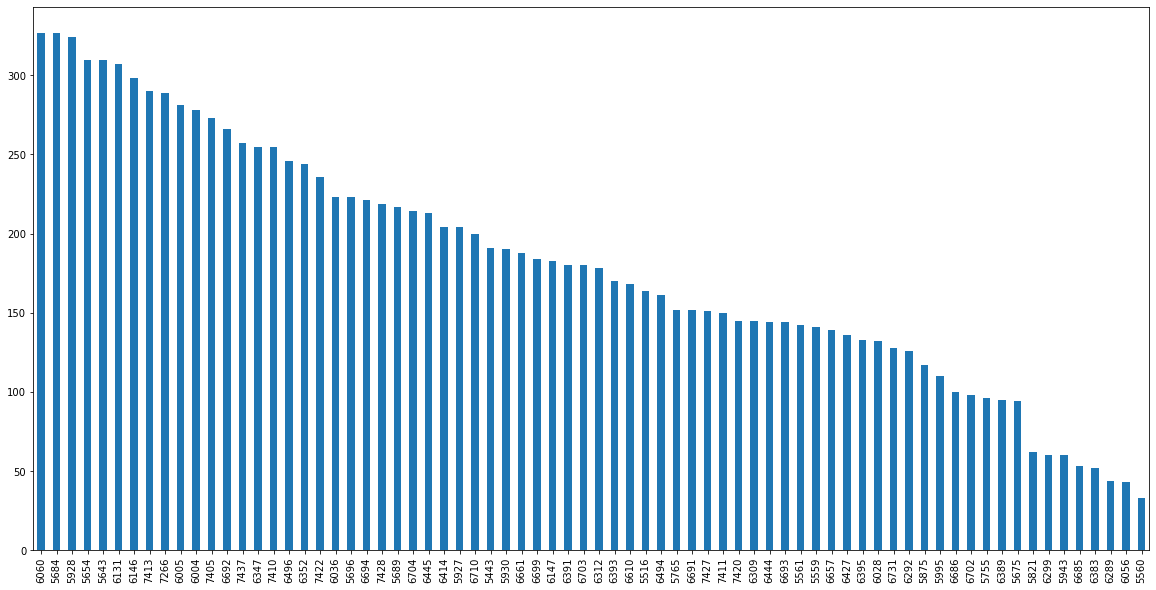

In [19]:
de_novo_df['fm_code'].value_counts()[int(len(denovo_per_fm)/2):].plot.bar(figsize=(20,10))

<AxesSubplot:xlabel='fm_code'>

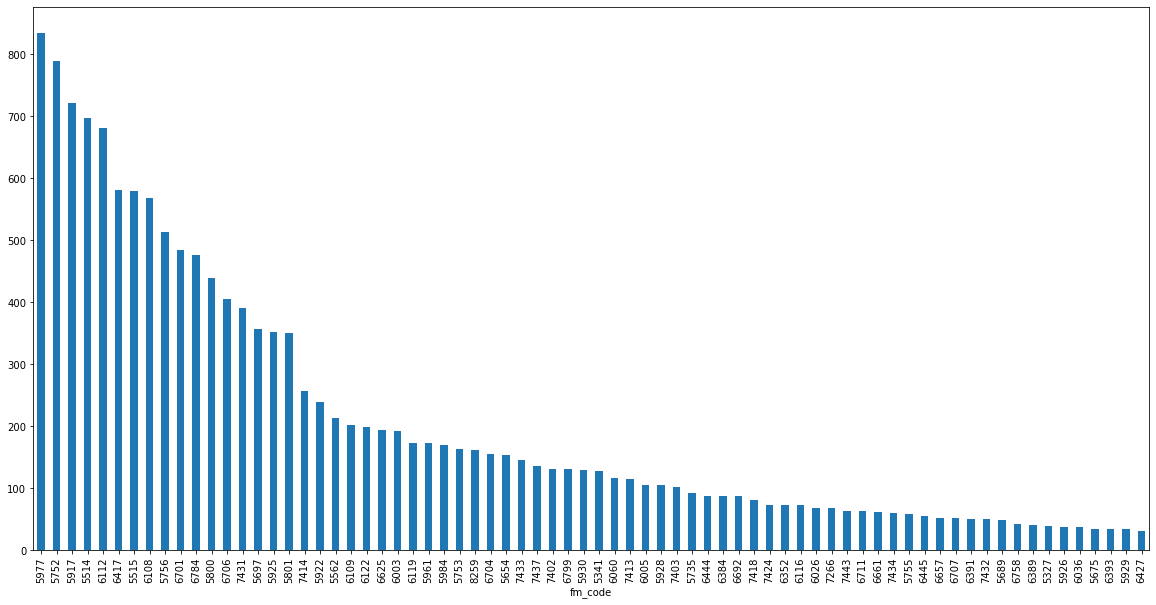

In [20]:
denovo_per_fm[:int(len(denovo_per_fm)/2)].plot.bar(figsize=(20,10))

<AxesSubplot:xlabel='fm_code'>

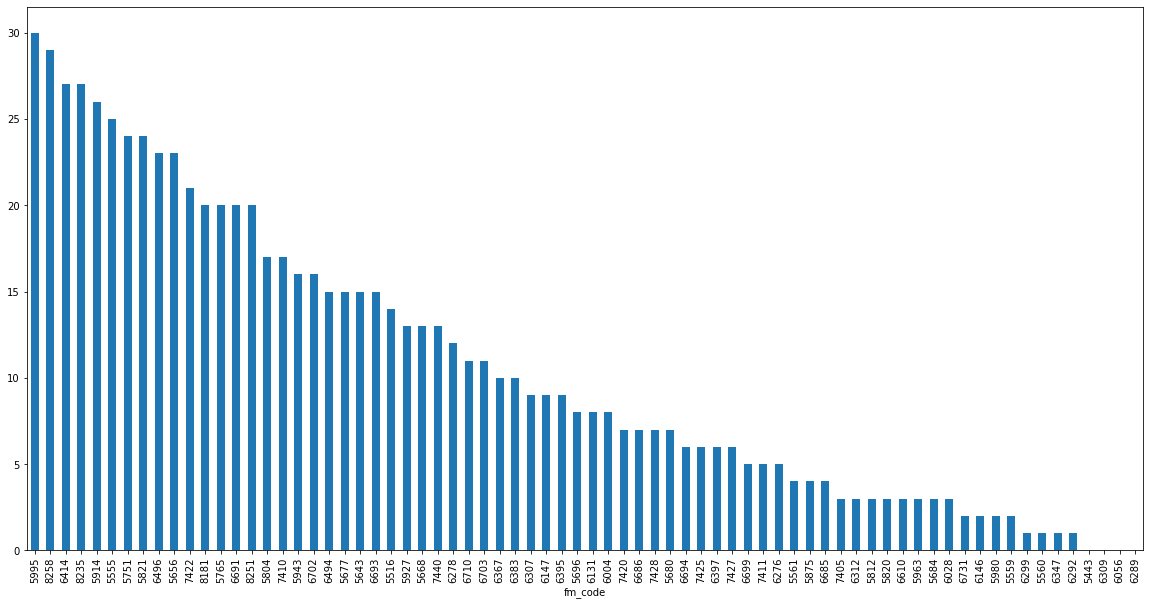

In [21]:
denovo_per_fm[int(len(denovo_per_fm)/2):].plot.bar(figsize=(20,10))

In [22]:
df_5977 = de_novo_df[(de_novo_df['fm_code'] == 5977) & (de_novo_df['de_novo'] == True)]
df_5977[df_5977['member'] == "offspring"]

,chr,numsnp,length,state_cn,loc,startsnp,endsnp,member,triostate,fm_code,de_novo,state,cn,chr_n,chr_s_s,chr_s_e
22744,chr1:934735-989219,78,54485,"state2,cn=1",/home/zluo/input/txt_orig/5977_2_1-1-121341441...,exm860,exm1389,offspring,332,5977,True,2,1,1,934735,989219
22746,chr1:1550992-1572310,23,21319,"state2,cn=1",/home/zluo/input/txt_orig/5977_2_1-1-121341441...,exm3957,exm2250017,offspring,332,5977,True,2,1,1,1550992,1572310
22750,chr1:35577702-35580837,14,3136,"state2,cn=1",/home/zluo/input/txt_orig/5977_2_1-1-121341441...,exm43481,exm43553,offspring,332,5977,True,2,1,1,35577702,35580837
22751,chr1:59122871-59175142,28,52272,"state2,cn=1",/home/zluo/input/txt_orig/5977_2_1-1-121341441...,rs232851,rs12073211,offspring,332,5977,True,2,1,1,59122871,59175142
22752,chr1:60287549-60338579,17,51031,"state2,cn=1",/home/zluo/input/txt_orig/5977_2_1-1-121341441...,exm63927,exm64014,offspring,332,5977,True,2,1,1,60287549,60338579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23641,chr21:30357039-30414793,32,57755,"state2,cn=1",/home/zluo/input/txt_orig/5977_2_1-1-121341441...,exm1564240,exm1564361,offspring,332,5977,True,2,1,21,30357039,30414793
23642,chr21:40572186-40669083,26,96898,"state2,cn=1",/home/zluo/input/txt_orig/5977_2_1-1-121341441...,exm1570763,rs13625,offspring,332,5977,True,2,1,21,40572186,40669083
23643,chr21:40781985-40826015,33,44031,"state2,cn=1",/home/zluo/input/txt_orig/5977_2_1-1-121341441...,exm1571066,rs8127431,offspring,332,5977,True,2,1,21,40781985,40826015
23645,chr21:44830955-44845968,20,15014,"state2,cn=1",/home/zluo/input/txt_orig/5977_2_1-1-121341441...,rs657918,exm1575070,offspring,532,5977,True,2,1,21,44830955,44845968


In [23]:
df_5752 = de_novo_df[(de_novo_df['fm_code'] == 5752) & (de_novo_df['de_novo'] == True)]
df_5752[df_5752['member'] == "offspring"]

,chr,numsnp,length,state_cn,loc,startsnp,endsnp,member,triostate,fm_code,de_novo,state,cn,chr_n,chr_s_s,chr_s_e
20648,chr1:35577702-35580837,14,3136,"state2,cn=1",/home/zluo/input/txt_orig/5752_2_1-1-116327827...,exm43481,exm43553,offspring,332,5752,True,2,1,1,35577702,35580837
20649,chr1:52911472-52991732,11,80261,"state2,cn=1",/home/zluo/input/txt_orig/5752_2_1-1-116327827...,exm1826447,exm1826547,offspring,332,5752,True,2,1,1,52911472,52991732
20652,chr1:60299125-60338579,15,39455,"state2,cn=1",/home/zluo/input/txt_orig/5752_2_1-1-116327827...,exm63937,exm64014,offspring,332,5752,True,2,1,1,60299125,60338579
20653,chr1:62672381-62673287,14,907,"state2,cn=1",/home/zluo/input/txt_orig/5752_2_1-1-116327827...,exm64661,exm64696,offspring,332,5752,True,2,1,1,62672381,62673287
20654,chr1:62905542-63329808,95,424267,"state2,cn=1",/home/zluo/input/txt_orig/5752_2_1-1-116327827...,exm64965,exm65436,offspring,332,5752,True,2,1,1,62905542,63329808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21541,chr21:24286536-24469110,15,182575,"state2,cn=1",/home/zluo/input/txt_orig/5752_2_1-1-116327827...,rs1349094,rs2827850,offspring,332,5752,True,2,1,21,24286536,24469110
21542,chr21:30407261-30421127,20,13867,"state2,cn=1",/home/zluo/input/txt_orig/5752_2_1-1-116327827...,variant.69424,indel.69431,offspring,332,5752,True,2,1,21,30407261,30421127
21543,chr21:34696502-34726019,21,29518,"state2,cn=1",/home/zluo/input/txt_orig/5752_2_1-1-116327827...,rs2834191,exm1567232,offspring,332,5752,True,2,1,21,34696502,34726019
21544,chr21:40572186-40670434,27,98249,"state2,cn=1",/home/zluo/input/txt_orig/5752_2_1-1-116327827...,exm1570763,exm2235004,offspring,332,5752,True,2,1,21,40572186,40670434


In [24]:
df_5917 = de_novo_df[(de_novo_df['fm_code'] == 5917) & (de_novo_df['de_novo'] == True)]
df_5917[df_5917['member'] == "offspring"]

,chr,numsnp,length,state_cn,loc,startsnp,endsnp,member,triostate,fm_code,de_novo,state,cn,chr_n,chr_s_s,chr_s_e
8917,chr1:871159-880167,20,9009,"state2,cn=1",/home/zluo/input/txt_orig/5917_2_1-1-022406193...,exm67,exm2253572,offspring,332,5917,True,2,1,1,871159,880167
8918,chr1:894315-898869,13,4555,"state2,cn=1",/home/zluo/input/txt_orig/5917_2_1-1-022406193...,exm410,exm554,offspring,332,5917,True,2,1,1,894315,898869
8919,chr1:1179365-1247826,80,68462,"state2,cn=1",/home/zluo/input/txt_orig/5917_2_1-1-022406193...,exm1975,exm2249777,offspring,332,5917,True,2,1,1,1179365,1247826
8920,chr1:1262635-1268482,31,5848,"state2,cn=1",/home/zluo/input/txt_orig/5917_2_1-1-022406193...,exm2695,exm2874,offspring,332,5917,True,2,1,1,1262635,1268482
8921,chr1:1550992-1566160,23,15169,"state2,cn=1",/home/zluo/input/txt_orig/5917_2_1-1-022406193...,exm3957,rs28464684,offspring,332,5917,True,2,1,1,1550992,1566160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9693,chr21:47783806-47856909,106,73104,"state2,cn=1",/home/zluo/input/txt_orig/5917_2_1-1-022406193...,exm1581702,exm1582176,offspring,332,5917,True,2,1,21,47783806,47856909
9694,chr22:17588617-17605899,23,17283,"state2,cn=1",/home/zluo/input/txt_orig/5917_2_1-1-022406193...,exm1583002,rs5748875,offspring,332,5917,True,2,1,22,17588617,17605899
9695,chr22:23523285-23524386,5,1102,"state2,cn=1",/home/zluo/input/txt_orig/5917_2_1-1-022406193...,exm1592502,exm1592561,offspring,332,5917,True,2,1,22,23523285,23524386
9696,chr22:46637445-46639613,19,2169,"state2,cn=1",/home/zluo/input/txt_orig/5917_2_1-1-022406193...,kgp15082934,kgp15080743,offspring,332,5917,True,2,1,22,46637445,46639613


In [25]:
df_5514 = de_novo_df[(de_novo_df['fm_code'] == 5514) & (de_novo_df['de_novo'] == True)]
df_5514[df_5514['member'] == "offspring"]

,chr,numsnp,length,state_cn,loc,startsnp,endsnp,member,triostate,fm_code,de_novo,state,cn,chr_n,chr_s_s,chr_s_e
54571,chr1:60299125-60338579,15,39455,"state2,cn=1",/home/zluo/input/txt_orig/5514_2_1-1-022406164...,exm63937,exm64014,offspring,352,5514,True,2,1,1,60299125,60338579
54573,chr1:63269479-63329808,22,60330,"state2,cn=1",/home/zluo/input/txt_orig/5514_2_1-1-022406164...,indel.3952,exm65436,offspring,352,5514,True,2,1,1,63269479,63329808
54575,chr1:67313187-67452140,28,138954,"state2,cn=1",/home/zluo/input/txt_orig/5514_2_1-1-022406164...,exm66991,exm67097,offspring,352,5514,True,2,1,1,67313187,67452140
54578,chr1:70611496-70650481,19,38986,"state2,cn=1",/home/zluo/input/txt_orig/5514_2_1-1-022406164...,exm67909,exm67969,offspring,552,5514,True,2,1,1,70611496,70650481
54580,chr1:77607160-77632493,8,25334,"state2,cn=1",/home/zluo/input/txt_orig/5514_2_1-1-022406164...,rs858447,exm69621,offspring,332,5514,True,2,1,1,77607160,77632493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55777,chr21:22652906-22676669,9,23764,"state2,cn=1",/home/zluo/input/txt_orig/5514_2_1-1-022406164...,exm1563288,rs8128815,offspring,352,5514,True,2,1,21,22652906,22676669
55778,chr21:24339568-24469110,14,129543,"state2,cn=1",/home/zluo/input/txt_orig/5514_2_1-1-022406164...,rs2827784,rs2827850,offspring,332,5514,True,2,1,21,24339568,24469110
55782,chr21:34048637-34086304,5,37668,"state2,cn=1",/home/zluo/input/txt_orig/5514_2_1-1-022406164...,variant.69554,rs607020,offspring,552,5514,True,2,1,21,34048637,34086304
55785,chr21:40572186-40604205,14,32020,"state2,cn=1",/home/zluo/input/txt_orig/5514_2_1-1-022406164...,exm1570763,exm1570832,offspring,552,5514,True,2,1,21,40572186,40604205


In [26]:
df_5977.triostate.value_counts()

332    801
532     22
331      4
335      3
221      3
321      2
Name: triostate, dtype: int64

In [27]:
df_5752.triostate.value_counts()

332    736
352     50
335      3
Name: triostate, dtype: int64

In [28]:
df_5917.triostate.value_counts()

332    716
335      2
321      2
331      1
Name: triostate, dtype: int64

In [29]:
df_5514.triostate.value_counts()

552    270
332    194
352    156
532     60
312      8
362      6
562      3
Name: triostate, dtype: int64

In [30]:
de_novo_df.triostate.value_counts()

332    11719
322     7728
232     5634
222     4545
555     3975
       ...  
133        3
636        2
213        2
653        2
366        2
Name: triostate, Length: 65, dtype: int64

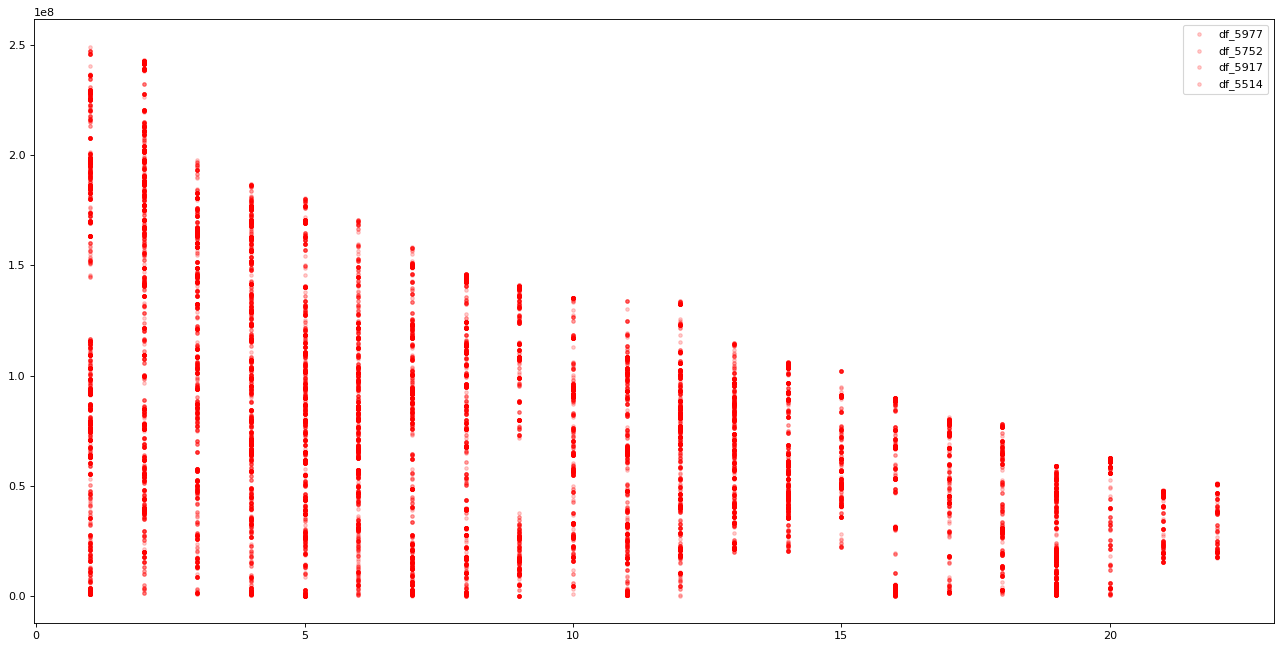

In [50]:
x = df_5977.chr_n
y = (df_5977.chr_s_s + df_5977.chr_s_e)/2
x2 = df_5752.chr_n
y2 = (df_5752.chr_s_s + df_5752.chr_s_e)/2
x3 = df_5917.chr_n
y3 = (df_5917.chr_s_s + df_5917.chr_s_e)/2
x4 = df_5514.chr_n
y4 = (df_5514.chr_s_s + df_5514.chr_s_e)/2
figure(figsize=(20, 10), dpi=80)
plt.scatter(x, y, s=10, alpha=0.2, c='red')
plt.scatter(x2, y2, s=10, alpha=0.2, c='red')
plt.scatter(x3, y3, s=10, alpha=0.2, c='red')
plt.scatter(x4, y4, s=10, alpha=0.2, c='red')
plt.legend(['df_5977', 'df_5752', 'df_5917', 'df_5514'])

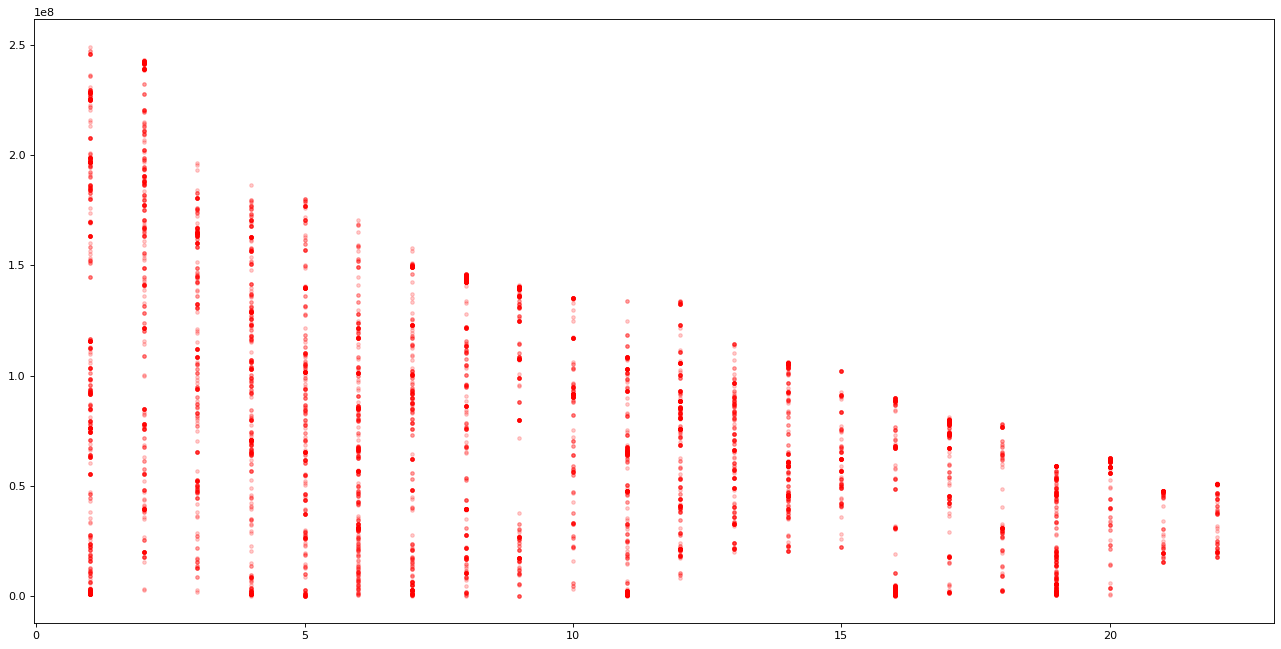

In [53]:
fm_less_denovo = denovo_per_fm[20:]
df_test = de_novo_df[(de_novo_df['fm_code'].isin(fm_less_denovo.index)) & (de_novo_df['de_novo'] == True)]
x_t = df_test.chr_n
y_t = (df_test.chr_s_s + df_test.chr_s_e)/2
figure(figsize=(20, 10), dpi=80)
plt.scatter(x_t, y_t, s=10, alpha=0.2, c='red')

In [22]:
denovo_per_chr = de_novo_df.groupby('chr_n')['de_novo'].sum()

<AxesSubplot:xlabel='chr_n'>

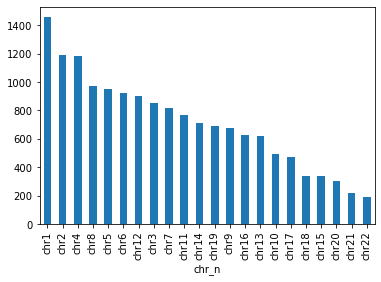

In [23]:
denovo_per_chr.sort_values(ascending=False).plot.bar()

P-value

In [65]:
de_novo_df[(de_novo_df['de_novo'] == True) & (de_novo_df['cn'] == 1)].sort_values(['fm_code', 'chr_n'])

,chr,numsnp,length,state_cn,loc,startsnp,endsnp,member,triostate,fm_code,de_novo,state,cn,chr_n,chr_s_s,chr_s_e
29470,chr1:16053627-16054062,8,436,"state2,cn=1",/home/zluo/input/txt_orig/5327_5_1-1-121341439...,exm19917,exm19944,offspring,312,5327,True,2,1,1,16053627,16054062
29506,chr1:95699811-95699841,3,31,"state2,cn=1",/home/zluo/input/txt_orig/5327_5_1-1-121341439...,exm76844,exm76847,offspring,312,5327,True,2,1,1,95699811,95699841
29516,chr1:151105169-151105831,3,663,"state2,cn=1",/home/zluo/input/txt_orig/5327_5_1-1-121341439...,exm95874,exm95898,offspring,312,5327,True,2,1,1,151105169,151105831
29532,chr1:227922866-227923195,4,330,"state2,cn=1",/home/zluo/input/txt_orig/5327_5_1-1-121341439...,exm154570,exm154589,offspring,312,5327,True,2,1,1,227922866,227923195
29536,chr1:228377913-228400211,6,22299,"state2,cn=1",/home/zluo/input/txt_orig/5327_5_1-1-121341439...,rs12084338,exm155228,offspring,312,5327,True,2,1,1,228377913,228400211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14071,chr19:20116641-20128389,12,11749,"state2,cn=1",/home/zluo/input/txt_orig/8259_2_1-1-037394911...,rs12327700,rs12977293,offspring,332,8259,True,2,1,19,20116641,20128389
14072,chr19:21365540-21366821,7,1282,"state2,cn=1",/home/zluo/input/txt_orig/8259_2_1-1-037394911...,exm2228758,exm1449483,offspring,332,8259,True,2,1,19,21365540,21366821
14107,chr20:58440438-58461828,23,21391,"state2,cn=1",/home/zluo/input/txt_orig/8259_2_1-1-037394911...,variant.68971,exm1554124,offspring,332,8259,True,2,1,20,58440438,58461828
14109,chr20:58489038-58496439,9,7402,"state2,cn=1",/home/zluo/input/txt_orig/8259_2_1-1-037394911...,exm1554192,exm1554220,offspring,352,8259,True,2,1,20,58489038,58496439


In [ ]:
for idx in range(0, len(path_lst), 3):
    fm_code = path_lst[idx][26:30]
    f1 = path_lst[idx]
    f2 = path_lst[idx + 1]
    f3 = path_lst[idx + 2]
    de_novo_df[(de_novo_df['de_novo'] == True) & (de_novo_df['cn'] == 1)].sort_values(['fm_code', 'chr_n'])
    print("running on " + out_file + " which is " + str(idx+1) + " out of " + str(length))
    #process = subprocess.run(["PennCNV-1.0.5/infer_snp_allele.pl", "-hmm", "/home/sal004/software/penncnv/lib/exome.hmm", "-pfb", "/home/sal004/software/penncnv/lib/humancoreexome-12v1-1_a.pfb", "-denovocn", "1", "--startsnp", startsnp, "--endsnp", endsnp, f1, f2, f3], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    #out, err = process.communicate()